In [2]:
import pandas as pd

In [3]:
covid_data = pd.read_csv('data/covid_data.csv')
display(covid_data.head())

,date,province/state,country,confirmed,deaths,recovered
0,01/22/2020,Anhui,China,1.0,0.0,0.0
1,01/22/2020,Beijing,China,14.0,0.0,0.0
2,01/22/2020,Chongqing,China,6.0,0.0,0.0
3,01/22/2020,Fujian,China,1.0,0.0,0.0
4,01/22/2020,Gansu,China,0.0,0.0,0.0


**Данные о показателях заболеваемости за каждый день в различных регионах 187 стран:**

* date — дата наблюдения;

* province/state — наименование провинции/штата;

* country — наименование страны;

* confirmed — общее число зафиксированных случаев на указанный день;

* deaths — общее число зафиксированных смертей на указанный день;

* recovered — общее число выздоровлений на указанный день.

In [4]:
vaccinations_data = pd.read_csv('data/country_vaccinations.csv')
vaccinations_data = vaccinations_data[
    ['country', 'date', 'total_vaccinations', 
     'people_vaccinated', 'people_vaccinated_per_hundred',
     'people_fully_vaccinated', 'people_fully_vaccinated_per_hundred',
     'daily_vaccinations', 'vaccines']
]

**данные о процессе вакцинирования людей в 221 стране мира:**

* country — наименование страны;

* date — дата наблюдения;

* total_vaccinations — общее число введённых вакцин в стране на указанный день;

* people_vaccinated — общее число привитых первым компонентом в стране на указанный день;

* people_vaccinated_per_hundred — процент привитых первым компонентом в стране на указанный день (рассчитывается как people_vaccinated / population * 100 );

* people_fully_vaccinated — общее число привитых вторым компонентом в стране на указанный день (первый компонент уже был введён им ранее);

* people_fully_vaccinated_per_hundred — процент привитых вторым компонентом в стране на указанный день (рассчитывается как people_fully_vaccinated / population * 100);

* daily_vaccination — ежедневная вакцинация (число вакцинированных в указанный день);

* vaccines — комбинации вакцин, используемые в стране.

**Примечание о данных**

В таблице covid_data данные о заболеваемости представлены для каждого региона (штата) страны за каждый день. Например, для США (United States) записи за 29 мая 2021 года имеют вид:

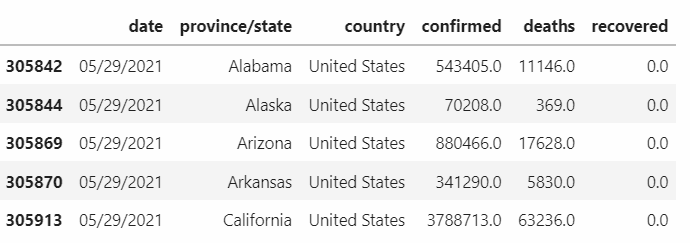

В таблице vaccinations_data параметры вакцинирования отображены для всех стран на каждый день, без учёта регионов. Вот часть таблицы для тех же Соединённых Штатов за 29 мая 2021 года. Как видите, она всего одна:

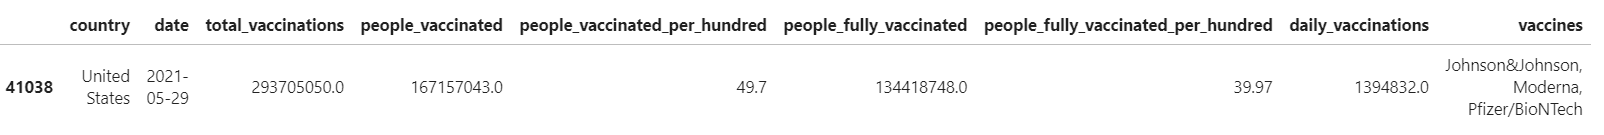

В данных много пропусков, а также неверно введённых значений. Например, для США (United States) и Великобритании (United Kingdom) в большинстве записей таблицы covid_data число выздоровевших людей равно 0. В данном модуле мы закроем на это глаза, но вообще эти страны подлежали бы исключению из данных или нам понадобился бы дополнительный источник данных, из которого мы смогли бы получить недостающую информацию.

Возникает большое желание объединить таблицы. Для этого необходимо учитывать следующие нюансы:

1. В таблице covid_data необходимо предварительно рассчитать суммарное ежедневное число заболевших во всех провинциях/штатах в каждой стране.

2. В таблицах не совпадает число стран, а иногда и их названия. 
    При объединении таблиц по столбцу мы определённо теряем данные (в данной задаче потери незначительны). Избежать этого можно ручными преобразованиями данных — искать различия в названиях стран в таблицах и преобразовывать их. Однако это не является темой данного модуля.

3. Таблицы имеют разные периоды наблюдений (вакцины появились позже, чем сам вирус). Объединив данные с типом inner, мы можем потерять большое количество наблюдений в таблице covid_data.

### Предобработка данных

Опираясь на замечания выше, выполним небольшую предобработку.

**В таблице covid_data:**

Группируем таблицу по дате и названию страны и рассчитываем суммарные показатели по всем регионам. Тем самым переходим от данных по регионам к данным по странам:

In [5]:
covid_data = covid_data.groupby(
    ['date', 'country'], 
    as_index=False
)[['confirmed', 'deaths', 'recovered']].sum()

Преобразуем даты в формат datetime с помощью функции pd.to_datetime():

In [6]:
covid_data['date'] = pd.to_datetime(covid_data['date'])

Создадим признак больных на данный момент (active). Для этого вычтем из общего числа зафиксированных случаев число смертей и число выздоровевших пациентов:

In [7]:
covid_data['active'] = covid_data['confirmed'] - covid_data['deaths'] - covid_data['recovered']

Создадим признак ежедневного прироста числа заболевших, умерших и выздоровевших людей. Для этого отсортируем данные по названиям стран, а затем по датам. После этого произведём группировку по странам и рассчитаем разницу между «вчера и сегодня» с помощью метода diff():

In [8]:
covid_data = covid_data.sort_values(by=['country', 'date'])
covid_data['daily_confirmed'] = covid_data.groupby('country')['confirmed'].diff()
covid_data['daily_deaths'] = covid_data.groupby('country')['deaths'].diff()
covid_data['daily_recovered'] = covid_data.groupby('country')['recovered'].diff()

В таблице **vaccinations_data** достаточно будет преобразовать столбцы в формат datetime:

In [9]:
vaccinations_data['date'] = pd.to_datetime(vaccinations_data['date'])

3.1. За какой период представлены данные в таблице covid_data? В качестве ответа введите даты в формате datetime (без указания времени).

In [10]:
print(f'Даные с {covid_data['date'].min()} по {covid_data['date'].max()}')

Даные с 2020-01-22 00:00:00 по 2021-05-29 00:00:00


3.2. За какой период представлены данные в таблице vaccinations_data? В качестве ответа введите даты в формате datetime без указания времени.

In [11]:
print(f'Даные с {vaccinations_data['date'].min()} по {vaccinations_data['date'].max()}')

Даные с 2020-12-02 00:00:00 по 2021-09-06 00:00:00


3.3 С помощью метода merge() объедините таблицы covid_data и vaccinations_data по столбцам date и country.
Тип объединения выставьте так, чтобы в результирующую таблицу попали только наблюдения за период, вычисленный в задании 3.1. То есть в результирующую таблицу должны попасть все записи из таблицы covid_data и из её пересечения с vaccinations_data, но не более. Результат объединения занесите в переменную covid_df.
Сохраните таблицу covid_df — она понадобится нам в следующем юните.

Сколько строк и столбцов в таблице covid_df?

In [12]:
covid_df = covid_data.merge(vaccinations_data, on= ['date', 'country'], how= 'left')
covid_df.shape


(86785, 16)

В получившейся в задании 3.3 таблице covid_df создайте признаки death_rate — общий процент смертей среди зафиксированных случаев (летальность) и recover_rate — общий процент случаев выздоровления. Данные характеристики рассчитайте как отношение числа смертей (deaths) и числа выздоровлений (recovered) к числу зафиксированных случаев (confirmed) и умножьте результаты на 100%.

In [13]:
covid_df['death_rate'] = (covid_df['deaths'] / covid_df['confirmed']) * 100
covid_df['recover_rate'] = (covid_df['recovered'] / covid_df['confirmed']) * 100
covid_df.head()

,date,country,confirmed,deaths,recovered,active,daily_confirmed,daily_deaths,daily_recovered,total_vaccinations,people_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated,people_fully_vaccinated_per_hundred,daily_vaccinations,vaccines,death_rate,recover_rate
0,2020-02-24,Afghanistan,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,2020-02-25,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,2020-02-26,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,2020-02-27,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,2020-02-28,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


Какова максимальная летальность в США (United States) за весь период? Ответ округлите до второго знака после запятой.

In [14]:
covid_df[covid_df['country'] == 'United States']['death_rate'].max()

7.18954248366013

Чему равен средний процент выздоровевших в России (Russia)? Ответ округлите до второго знака после запятой.

In [15]:
covid_df[covid_df['country'] == 'Russia']['recover_rate'].mean()

67.06273489477655

# Базовая визуализация в Pandas

## Основные параметры метода plot():

* x — название признака, который будет отложен по оси абсцисс;

* y — название признака, который будет отложен по оси ординат;

* figsize — размер графика (кортеж из ширины и высоты в дюймах);

* kind —тип визуализации. Основные типы:

* 'line' — линейный график (по умолчанию);

* 'bar' — столбчатая диаграмма;

* 'barh' — горизонтальная столбчатая диаграмма;

* 'hist' — гистограмма;

* 'box' — коробчатая диаграмма (boxplot);

* 'pie' — круговая диаграмма;

* 'scatter' — диаграмма рассеяния.

* grid — отображение сетки (по умолчанию False);

* legend — отображение легенды (по умолчанию False);

* title — название графика;

* color — цвет.

Давайте попрактикуемся в использовании метода plot().

Начнём с исследования заболеваемости коронавирусом во всём мире. Для этого первым делом отобразим, как менялось ежедневное число заболевших (daily_confirmed) во всём мире во времени. Далее сгруппируем таблицу по датам и подсчитаем суммарное число зафиксированных случаев по дням.

Теперь мы наконец можем построить график с помощью метода plot(). Будем использовать линейный график размером 12x4 (попробуйте взять другие числа, чтобы увидеть разницу). Подпишем график и отобразим сетку. Параметр lw (line width) отвечает за ширину линии для линейного графика.

<Axes: title={'center': 'Ежедневная заболеваемость во времени'}, xlabel='date'>

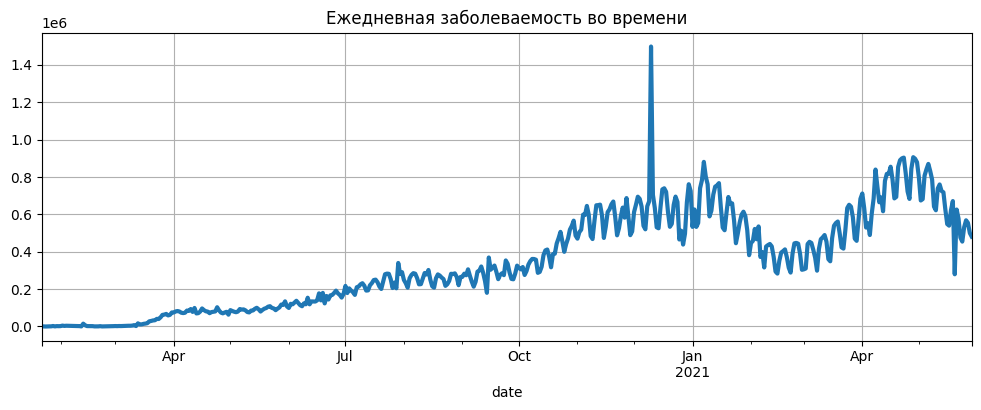

In [16]:
grouped_cases = covid_df.groupby('date')['daily_confirmed'].sum()
grouped_cases.plot(
    kind='line',
    figsize=(12, 4),
    title='Ежедневная заболеваемость во времени',
    grid = True,
    lw=3
)

**Примечание**. Обратите внимание, что мы не использовали параметры x и y. Это связано с тем, что в нашем случае переменная grouped_cases — это объект Series.

plot() может являться методом объекта типа DataFrame или Series. При типе DataFrame требуется указать х и у, либо будут построены графики всех столбцов. При типе Series в этом нет необходимости, ведь это и так всего один столбец данных (у) с индексами (х).

При этом по оси абсцисс (х) откладываются индексы (на сгруппированных данных grouped_cases индексы — это даты), а по оси ординат (у) — значения показателей.

Здесь и далее в модуле точка с запятой в последней строке кода используется во избежание вывода на экран служебной информации в ноутбуке (попробуйте её убрать и посмотрите, что будет).

Теперь построим **гистограмму**, которая покажет распределение ежедневной заболеваемости во всём мире. Для этого параметр kind выставляем на значение 'hist'. Параметр bins (корзины) отвечает за число прямоугольников в гистограмме — пусть их будет 10 (попробуйте использовать другие числа, чтобы увидеть разницу).

<Axes: title={'center': 'Распределение ежедневной заболеваемости'}, ylabel='Frequency'>

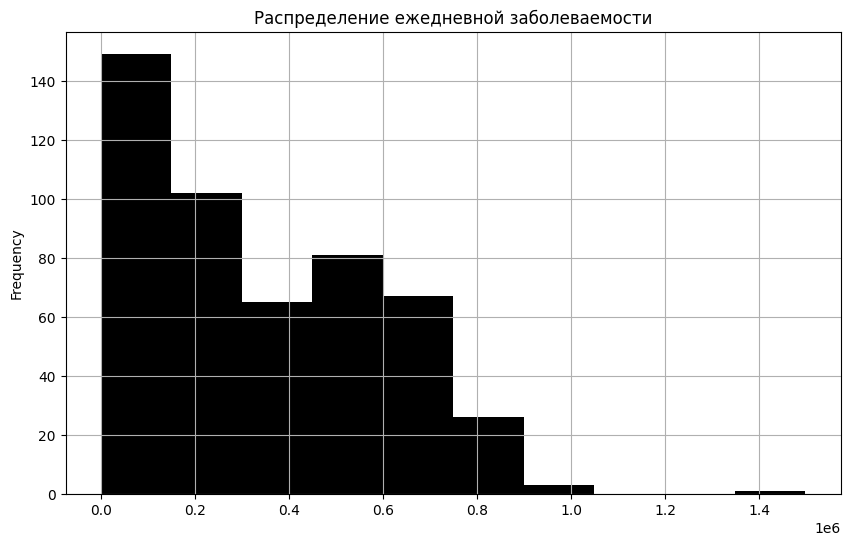

In [17]:
grouped_cases.plot(
    kind='hist',
    figsize=(10, 6),
    title='Распределение ежедневной заболеваемости',
    grid = True,
    color = 'black',
    bins=10
)

Давайте построим **столбчатую** диаграмму, которая покажет ТОП-10 стран по суммарной заболеваемости.

Для этого сгруппируем данные по странам и вычислим последний зафиксированный показатель с помощью агрегирующего метода last() — он возвращает последнее значение в столбце DataFrame.

Для построения столбчатой диаграммы значение параметра kind выставляем на 'bar'. Параметр colormap отвечает за цветовую гамму графика.

<Axes: xlabel='country'>

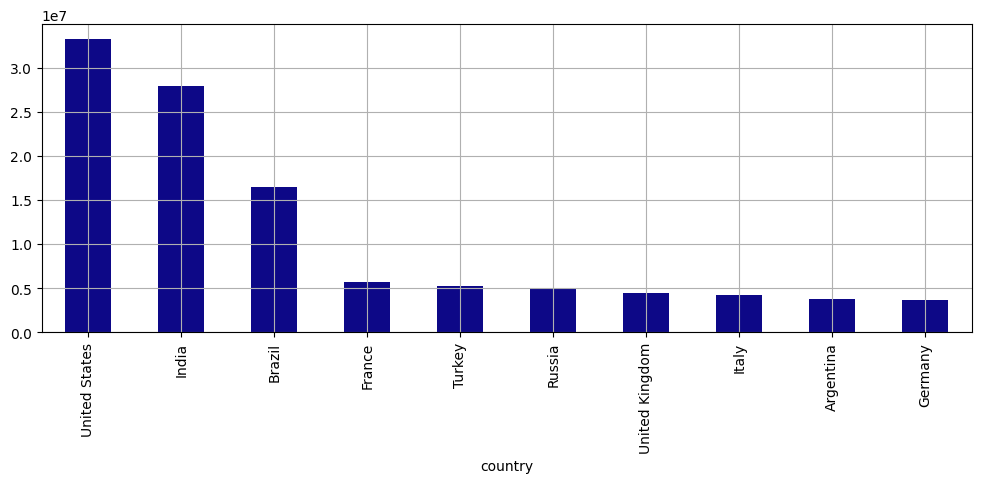

In [18]:
grouped_country = covid_df.groupby(['country'])['confirmed'].last()
grouped_country = grouped_country.nlargest(10)
grouped_country.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    colormap='plasma'
)

А теперь посмотрим, как в этих десяти странах соотносится количество заболевших и умерших от вируса. Для этого отобразим сразу два показателя на столбчатой диаграмме: 

<Axes: xlabel='country'>

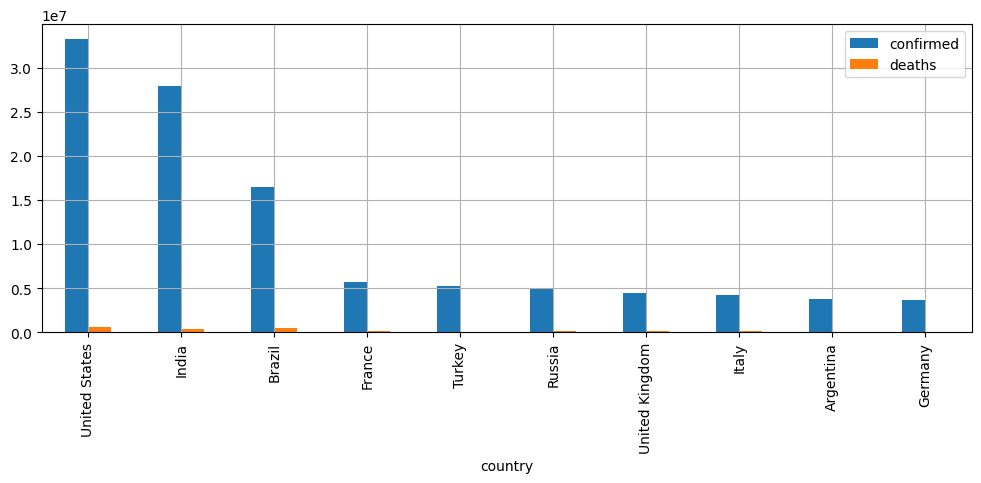

In [19]:
grouped_country = covid_df.groupby(['country'])[['confirmed', 'deaths']].last()
grouped_country = grouped_country.nlargest(10, columns=['confirmed'])
grouped_country.plot(     kind='bar',     grid=True,     figsize=(12, 4), )

<Axes: xlabel='country'>

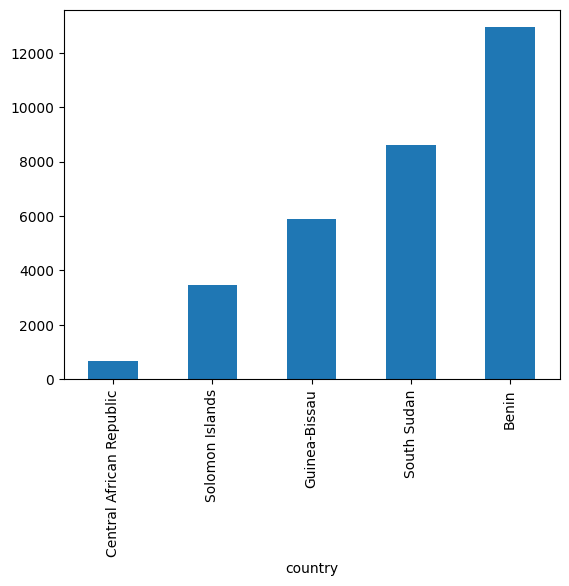

In [20]:
covid_df.groupby(['country'])['total_vaccinations'].last().nsmallest(5).plot(kind='bar')

За визуализацию графиков в Matplotlib отвечает модуль pyplot. Традиционно он импортируется под псевдонимом plt. Для более корректного отображения графиков в ноутбуках используется команда %matplotlib inline.

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

# Основные объекты Matplotlib

Библиотека Matplotlib позволяет работать в нескольких режимах. Самый распространённый и мощный по функционалу — объектно-ориентированный режим. Он основан на работе с объектами фигур (figure, их ещё называют канвасами или холстами) и координатных плоскостей (axes, или системы координат). 

На рисунке ниже представлена визуализация основных компонентов графика в Matplotlib:

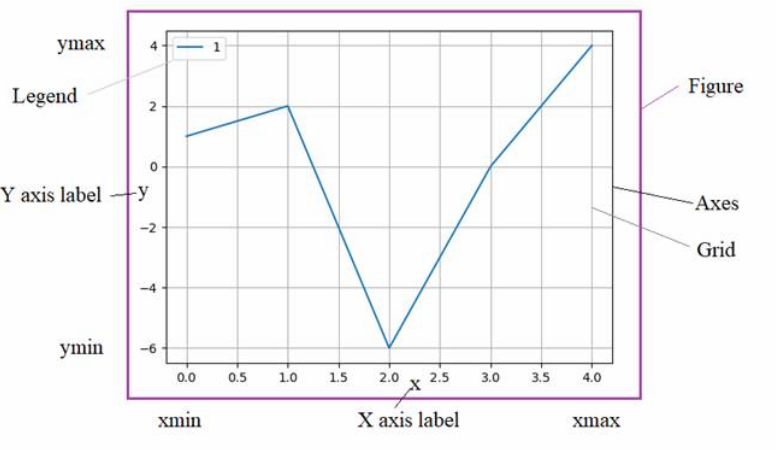

Процесс работы над графиком максимально прозрачен: сначала создаётся объект фигуры (fig) , содержащий необходимую информацию и настройки, например размер в дюймах (figsize, восемь дюймов в ширину, четыре — в высоту). К этому объекту с помощью метода add_axes() добавляется координатная плоскость, а на ней располагаются графические объекты. Для создания координатной плоскости необходимо указать её расположение на фигуре в виде списка из координат. В нашем случае она начинается в левом нижнем углу без отступов (координаты 0, 0) и занимает всё отведённое место в области (100%, ширина и высота равны 1).

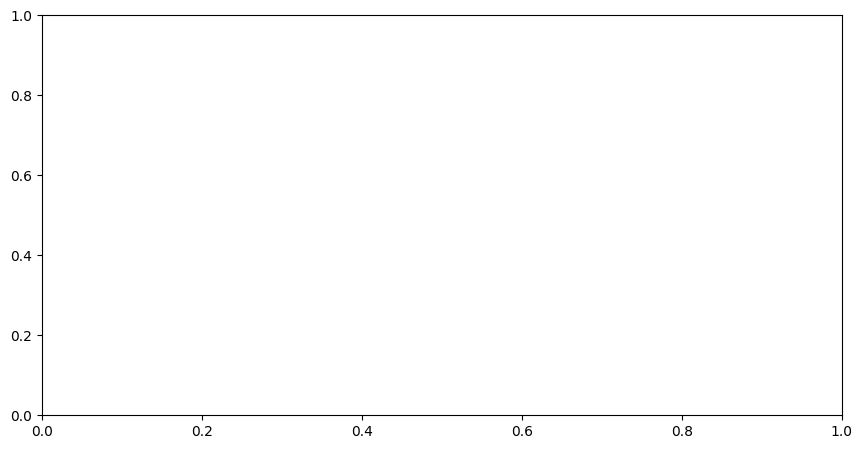

In [22]:
fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])

Теперь на созданной системе координат мы можем построить график. 

Утверждается, что коллективная вакцинация позволяет минимизировать риск заражения коронавирусной инфекцией (но только после второго компонента). Давайте проверим это на примере США: построим диаграмму рассеяния, которая покажет зависимость числа ежедневно обнаруживаемых случаев заражения (daily_confirmed) от общего количества привитых вторым компонентом вакцины (people_fully_vaccinated) в США.

У объекта координатной плоскости axes вызовем метод scatter().

**Основные параметры метода scatter():**

* x, y — последовательности, которые будут отложены по осям абсцисс и ординат;

* s — размер маркеров;

* marker — вид маркеров ('o' — точки, '^' — треугольники);

* c — цвет маркеров.

На диаграмме рассеяния по оси абсцисс откладываем суммарное число поставленных вакцин, а по оси ординат — ежедневный прирост заболевших:

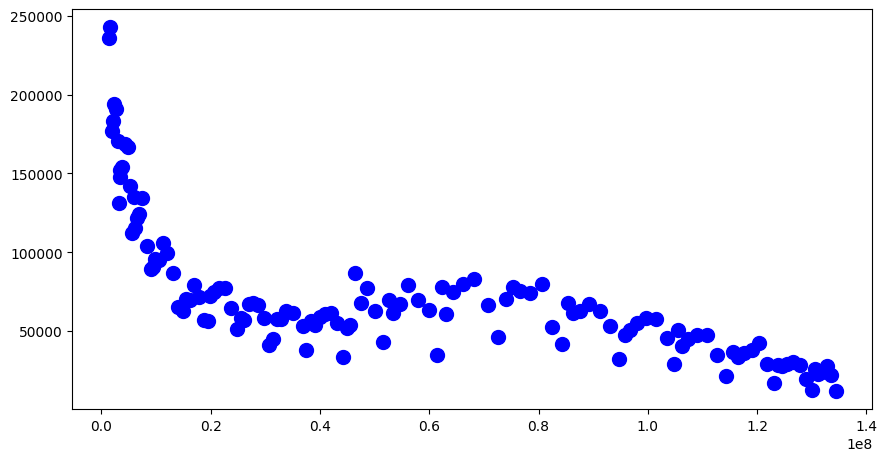

In [23]:
us_data = covid_df[covid_df['country'] == 'United States']

fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.scatter(
    x=us_data['people_fully_vaccinated'], 
    y=us_data['daily_confirmed'], 
    s=100,
    marker='o',
    c = 'blue'
)

Построим круговую диаграмму, чтобы отобразить ТОП-10 комбинаций вакцин в мире.

Примечание. Обратите внимание, что под «распространённостью» вакцины здесь подразумевается не количество введённых доз (таких данных у нас в таблице нет), а количество стран, в которых она используется. При этом подсчёт ведётся не по каждой отдельной вакцине, а по их комбинациям, и одна и та же вакцина учитывается несколько раз в сочетаниях с другими.

Для построения круговых диаграмм в Matplotlib используется метод pie().

**Основные параметры метода pie():**

* x — значения, по которым будет строиться круговая диаграмма;

* labels — метки, соответствующие значениям;

* autopct — формат отображения долей на диаграмме (например, '%.1f%%' означает, что округление будет производиться до первого знака после запятой и при выводе будет указан знак "%"; открывающий и закрывающий проценты означают форматирование, а внутренний — вывод знака "%");

* explode — последовательность, которая определяет долю смещения сектора от центра для каждого значения из x.

ТОП-10 комбинаций вакцин (vaccines) по распространённости мы находим с помощью метода value_counts(). Круговую диаграмму строим на полученных значениях, метки для каждого значения — индексы промежуточной таблицы. Будем отображать доли в процентах и округлять их до одного знака после запятой. Самую распространённую вакцину сместим на 10 % от центра:

([<matplotlib.patches.Wedge at 0x208636ee7b0>,
 [Text(0.7665420934957, 0.9232622698341083, 'Johnson&Johnson, Moderna, Oxford/AstraZeneca, Pfizer/BioNTech'),
  Text(-0.5931469540063179, 0.9263782655875661, 'Oxford/AstraZeneca'),
  Text(-1.0669756518152362, 0.26751253883407417, 'Moderna, Oxford/AstraZeneca, Pfizer/BioNTech'),
  Text(-0.9691397141646498, -0.5203539318856552, 'Oxford/AstraZeneca, Sinopharm/Beijing'),
  Text(-0.42855913880528995, -1.013082950476647, 'Oxford/AstraZeneca, Pfizer/BioNTech'),
  Text(0.162764772670222, -1.0878913680959192, 'Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V'),
  Text(0.6404448584916131, -0.894332367317463, 'Moderna, Pfizer/BioNTech'),
  Text(0.9150658010408986, -0.610454404329577, 'Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing'),
  Text(1.03477305208093, -0.3731551027215323, 'Pfizer/BioNTech'),
  Text(1.092724197741022, -0.126308462389659, 'Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac, Sputnik V')],
 [Text(0.4471495545391

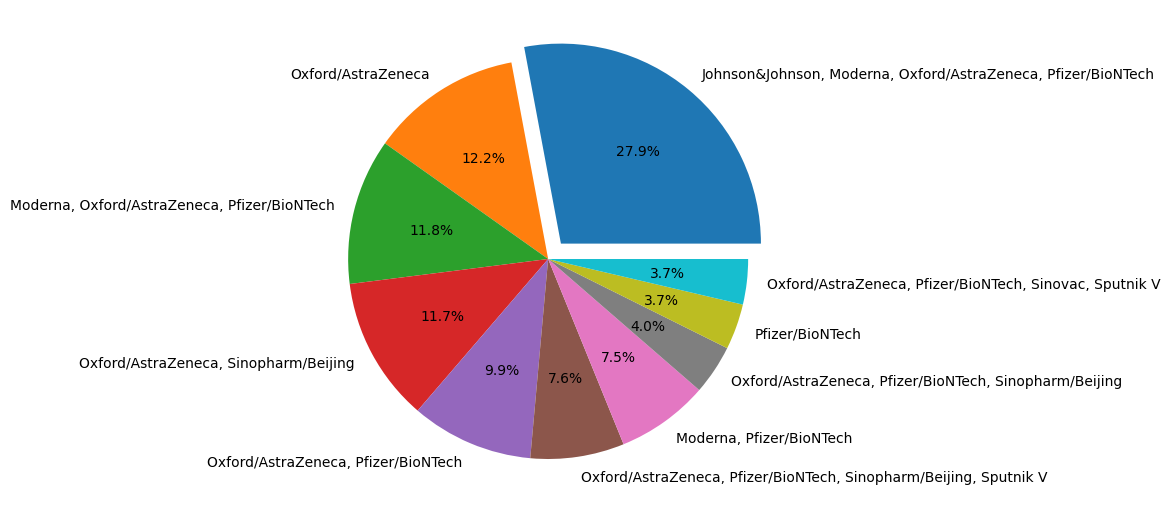

In [24]:
vaccine_combinations = covid_df['vaccines'].value_counts()[:10]
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    vaccine_combinations,
    labels=vaccine_combinations.index,
    autopct='%.1f%%',
    explode = [0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
)

### Информативность графика
Управлять информативностью графика можно с помощью методов координатной плоскости axes. Перечислим основные из них (не пугайтесь, запоминать их не обязательно — вы всегда сможете подсмотреть их в документации):

* axes.set_title() — заголовок диаграммы, а также его настройки (например, параметр fontsize отвечает за размер шрифта);

* axes.set_xlabel() — название оси абсцисс;

* axes.set_ylabel() — название оси ординат;

* axes.set_xticks() — установка отметок на оси абсцисс;

* axes.set_yticks() — установка отметок на оси ординат;

* axes.xaxis.set_tick_params() — управление параметрами отметок на оси абсцисс (например, параметр rotation отвечает за поворот отметок в градусах);

* axes.yaxis.set_tick_params() — управление параметрами отметок на оси ординат;

* axes.legend() — отображение легенды;

* axes.grid() — установка сетки.

Например, изобразим на одном графике, как росла общая заболеваемость (confirmed), число зафиксированных смертей (deaths), выздоровевших пациентов (recovered) и активных случаев (active) в Китае.

Для построения линейных графиков в Matplotlib используется метод plot() (не путайте с методом plot() в Pandas!). При вызове метода без параметров по оси ординат откладываются значения столбца таблицы, по оси абсцисс — индексы (в нашем случае это будут даты). 

Дополнительно в параметрах метода указываем параметр label — название графика, которое будет отображаться на легенде, а также lw — ширину линии графика. Добавим к графику заголовок, названия осей, установим метки по оси y с частотой в 10 000, повернём метки по оси x на 30 градусов, а также добавим легенду (метки для легенды выставляются в параметре label метода plot()):

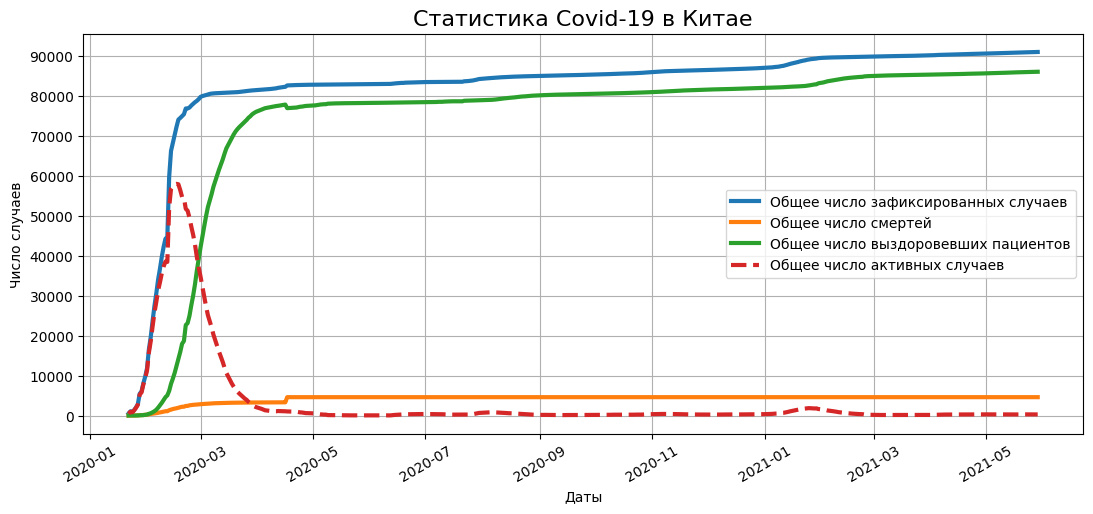

In [28]:
china_data = covid_df[covid_df['country'] == 'China']
china_grouped = china_data.groupby(['date'])[['confirmed', 'active', 'deaths', 'recovered']].sum()

#визуализация графиков
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.plot(china_grouped['confirmed'], label='Общее число зафиксированных случаев', lw=3)
axes.plot(china_grouped['deaths'], label='Общее число смертей', lw=3)
axes.plot(china_grouped['recovered'], label='Общее число выздоровевших пациентов', lw=3)
axes.plot(china_grouped['active'], label='Общее число активных случаев', lw=3, linestyle='dashed')

#установка параметров отображения
axes.set_title('Статистика Covid-19 в Китае', fontsize=16)
axes.set_xlabel('Даты')
axes.set_ylabel('Число случаев')
axes.set_yticks(range(0, 100000, 10000))
axes.xaxis.set_tick_params(rotation=30)
axes.grid()
axes.legend()

### Использование нескольких систем координат

При использовании библиотеки Matplotlib вовсе не обязательно ограничиваться одной системой координат.

→ Вы можете размещать несколько систем координат на одной фигуре, что позволит нам отображать вспомогательную информацию на основном графике.

Для добавления второй системы координат необходимо повторно применить к объекту fig метод add_axes, указав новое имя для второй системы координат.

Например, отобразим ТОП-5 стран по общему числу привитых вторым компонентом людей (people_fully_vaccinated), а также ТОП-5 стран по числу полностью привитых на 100 человек населения (people_fully_vaccinated_per_hundred).

Для этого построим столбчатые диаграммы с помощью метода bar().
**Онсновные параметры метода bar():**

* x — названия категорий, которые будут располагаться по оси абсцисс;

* height — высота столбцов диаграммы, массив из показателей для визуализации (например, среднее, максимальное значение и т. д.);

* width — ширина столбцов диаграммы;

* color — цвет.

Группируем таблицу по странам, находим последний по дате зафиксированный показатель с помощью метода last() и выбираем ТОП-5 стран с использованием метода nlargest().

При отображении графиков создаём две координатные плоскости main_axes и insert_axes, на каждой из них отдельно строим столбчатые диаграммы.

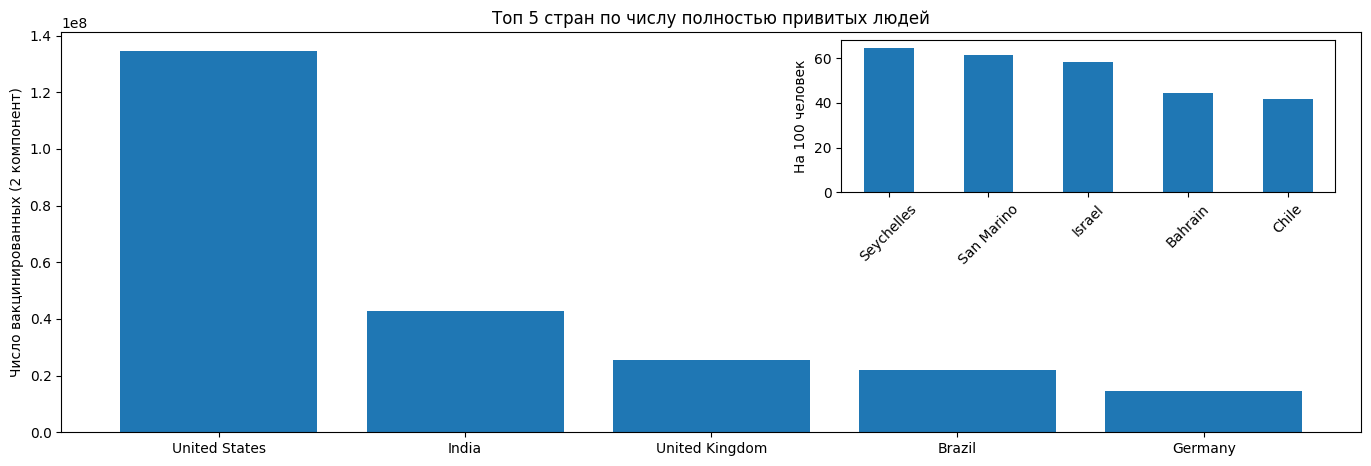

In [27]:
vacc_country = covid_df.groupby('country')['people_fully_vaccinated'].last().nlargest(5)
vacc_country_per_hundred = covid_df.groupby('country')['people_fully_vaccinated_per_hundred'].last().nlargest(5)

#визуализация главного графика
fig = plt.figure(figsize=(13, 4))
main_axes = fig.add_axes([0, 0, 1, 1])
main_axes.bar(x = vacc_country.index, height = vacc_country);
main_axes.set_ylabel('Число вакцинированных (2 компонент)')
main_axes.set_title('Топ 5 стран по числу полностью привитых людей')

#визуализация вспомогательного графика
insert_axes = fig.add_axes([0.6, 0.6, 0.38, 0.38])
insert_axes.bar(x = vacc_country_per_hundred.index, height = vacc_country_per_hundred, width=0.5);
insert_axes.set_ylabel('На 100 человек')
insert_axes.xaxis.set_tick_params(rotation=45)

**Примечание**. Первые два числовых параметра, указанные при создании систем координат, — это отступ снизу и слева, следующие два — ширина и высота относительно ширины и высоты всего пространства (в долях единицы) для построения графика.

# SUBPLOTS

Создание дополнительных систем координат с помощью метода add_axes() полезно, однако используется не так часто.

В большинстве случаев для отображения нескольких систем координат используется функция subplots(). Она создаёт целую таблицу из систем координат на одной фигуре. Функция возвращает новую фигуру, а также список координатных плоскостей.

Основные параметры метода subplots():

* nrows — число строк;

* ncols — число столбцов;

* figsize — общий размер фигуры в дюймах (ширина и высота).

Например, следующий код создаст шесть координатных плоскостей, сведённых в таблицу размера 2x3:

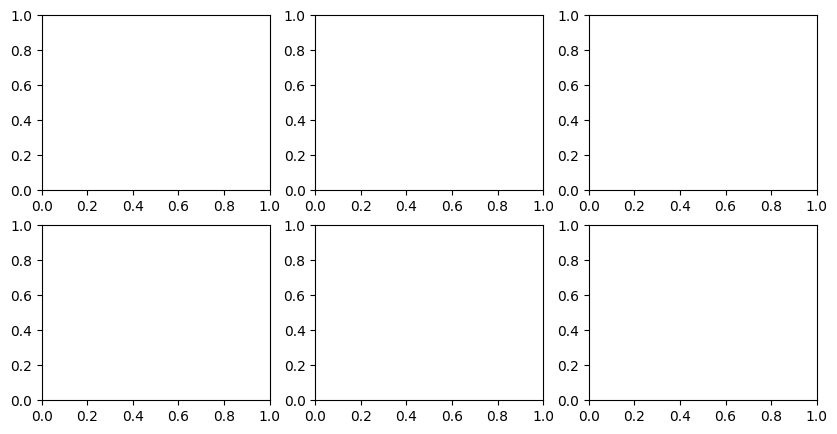

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))

Теперь, обладая знаниями о методе subplots(), построим три графика:

Столбчатую диаграмму, которая покажет динамику ежедневной вакцинации в России.
Линейный график изменения ежедневной заболеваемости в стране.
Гистограмму ежедневной заболеваемости в стране.
За построение гистограмм в библиотеке Matplotlib отвечает метод hist().

Осовные параметры метода hist():

* x — массив чисел, для которого строится гистограмма;

* bins — число столбцов (корзин);

* orientation — ориентация гистограммы (по умолчанию 'vertical');

* color — цвет.

Фильтруем таблицу covid_data по признаку страны и выбираем записи только для России.

Для того чтобы отобразить график в соответствующей координатной плоскости, нужно обратиться к списку axes по индексу (от 0 до 2). Дальнейшая настройка графиков вам уже известна.



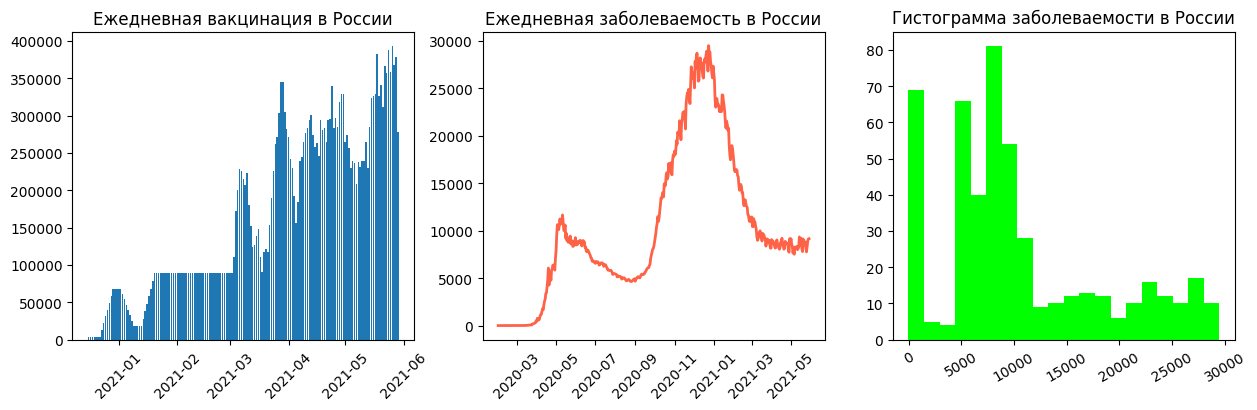

In [30]:
russia_data = covid_df[covid_df["country"] == "Russia"]

# визуализация систем координат
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

# столбчатая диаграмма
axes[0].bar(
    x=russia_data["date"],
    height=russia_data["daily_vaccinations"],
    label="Число вакцинированных",
)
axes[0].set_title("Ежедневная вакцинация в России")
axes[0].xaxis.set_tick_params(rotation=45)

# линейный график
axes[1].plot(
    russia_data["date"],
    russia_data["daily_confirmed"],
    label="Число заболевших",
    color="tomato",
    lw=2,
)
axes[1].set_title("Ежедневная заболеваемость в России")
axes[1].xaxis.set_tick_params(rotation=45)

# гистограмма
axes[2].hist(
    x=russia_data["daily_confirmed"], label=["Число заболевших"], color="lime", bins=20
)
axes[2].set_title("Гистограмма заболеваемости в России")
axes[2].xaxis.set_tick_params(rotation=30)